# Filter for Continuous Range

Not really a filter, but named as such for document conventions.

In order to accurately represent signals that can continuously add more and more range, forever, a patch was made to allow the continuation of the magntiudes outside of their previous clamped ranges. Heading is the main signal in question here, since it can increase/decerase forever- even though 365 = 5degrees. The large zero cross hop to the equal angle within the clamped range causes misrepresentation errors in statistical analyses and needs to be fixed before those calculations occur.

Note that after these patches, signal magnitudes may become quite large and are only for helping the statistical tests. 

## Method

Once a signal falls below the full scale range, it hops to the upper bound of the range to the equal angle (for heading signals). Testing for large differences between single sample indices show these points, which will determine the magnitude to subtract all following elements by.

In [1]:
import matplotlib.pyplot as plt
from decode import decode_tile

# explicitly import tile and overriding the default continuous range fix (what this notebook explores)
tile_2023_12_30 = decode_tile(
    "../DATA/2023_12_30/Mt Olympia/Tile/SENS000.CSV", 
    print_out=True, 
    header="Tile Full Recording",
    orientation_corrections=[False, False, False],
)

Tile Full Recording
	 Duration [s] 1975


In [2]:
def fixZeroCrossings(x, m=0.5, full_scale=360):
    y = x
    skips = []
    for i in range(len(x)):
        if i == 0: continue
        # if x[i] > 0 and x[i] - x[i - 1] >= (m * full_scale): NOPE
        if x[i] > x[i - 1] and abs(x[i] - x[i - 1]) >= (m * full_scale):
            skips.append([i - 11, i + 10])
            # sub cm from xi and all following el until the opposite crossing
            for j in range(len(x) - i):
                y[i + j] = x[i + j] - full_scale
                # if x[i] < 0 and x[i] - x[i - 1] <= -(m * full_scale): NOPE
                if x[i] < x[i - 1] and abs(x[i] - x[i - 1]) >= (m * full_scale):
                    skips.append([i - 11, i + 10])
                    break
            continue

        # if x[i] < 0 and x[i] - x[i - 1] <= -(m * full_scale): NOPE
        if x[i] < x[i - 1] and abs(x[i] - x[i - 1]) >= (m * full_scale):
            skips.append([i - 11, i + 10])
            # sub cm from xi and all following el until the opposite crossing
            for j in range(len(x) - i):
                y[i + j] = x[i + j] + full_scale
                # if x[i] > 0 and x[i] - x[i - 1] >= (m * full_scale): NOPE
                if x[i] > x[i - 1] and abs(x[i] - x[i - 1]) >= (m * full_scale):
                    skips.append([i - 11, i + 10])
                    break
            continue
    return y, skips

    # TODO recursive method

    # print(len(x))
    # m = 0.95
    # y = x
    # for i in range(len(x) - 1):
    #     # if i == 0: continue
    #     y[i] = x[i] + c
    #     if x[i + 1] > 0 and (x[i + 1] - x[i]) >= (m * full_scale):
    #         fixZeroCrossings(x[i + 1:], -full_scale)

    #     if x[i + 1] < 0 and (x[i + 1] - x[i]) <= -(m * full_scale):
    #         fixZeroCrossings(x[i + 1:], full_scale)
    # return y

### Adjustment of `m`

Since a signal will rarely - even in impulses - jump half its dynamic range, `m` was adjusteed with trial & error so it captures only the skipping points associated with range error.

In [3]:
patched_yaw_m9, skips9 = fixZeroCrossings(tile_2023_12_30.euler9[:, 2].tolist(), 0.9)
print(len(skips9), 'skips from m = 0.9:', skips9)
patched_yaw_m5, skips5 = fixZeroCrossings(tile_2023_12_30.euler9[:, 2].tolist(), 0.5)
print(len(skips5), 'skips from m = 0.5:', skips5)

105 skips from m = 0.9: [[1260, 1281], [1420, 1441], [1438, 1459], [1554, 1575], [21109, 21130], [21136, 21157], [21214, 21235], [21520, 21541], [21529, 21550], [22114, 22135], [22182, 22203], [23328, 23349], [23356, 23377], [23763, 23784], [24318, 24339], [36619, 36640], [36662, 36683], [38550, 38571], [38573, 38594], [43726, 43747], [43882, 43903], [48426, 48447], [87217, 87238], [87371, 87392], [91499, 91520], [91539, 91560], [92982, 93003], [95927, 95948], [96066, 96087], [96244, 96265], [96346, 96367], [96546, 96567], [96683, 96704], [97903, 97924], [98070, 98091], [98224, 98245], [98308, 98329], [98422, 98443], [98514, 98535], [98630, 98651], [98705, 98726], [98874, 98895], [98937, 98958], [99105, 99126], [99136, 99157], [99144, 99165], [99152, 99173], [99153, 99174], [99154, 99175], [99163, 99184], [99166, 99187], [107650, 107671], [107916, 107937], [115569, 115590], [115745, 115766], [140118, 140139], [140542, 140563], [140547, 140568], [140553, 140574], [149972, 149993], [1500

In [4]:
def plotYaw(y_m9, y_m5=None, r=[0, -1], w=10, h=4):
    plt.rc('lines', linewidth=1)
    _, ax = plt.subplots(figsize=(w, h))

    ax.plot(tile_2023_12_30.euler9[r[0]:r[1], 2], label='clamped')
    ax.plot(y_m9[r[0]:r[1]], label='cts m=0.9')
    ax.plot(y_m5[r[0]:r[1]], label='cts m=0.5') if y_m5 is not None else []
    ax.set_title('Yaw', wrap=True)
    ax.legend()

    plt.show()

### Searching Down the Signal (All 9dof)

Checking out the points of continuous rotation, leads to lower `m` magnitudes since the signal is continuously decreasing/increasing.

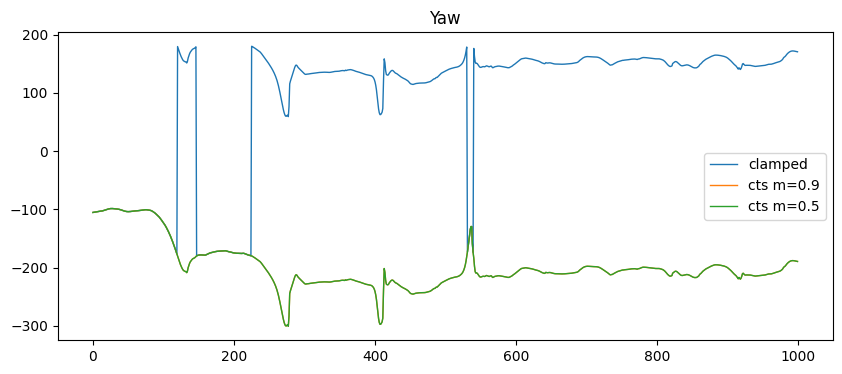

In [5]:
r_of_interest = [21000, 22000]
plotYaw(y_m9=patched_yaw_m9, y_m5=patched_yaw_m5, r=r_of_interest)

Still points of skipping, since the error observed at those points were greater than the dynamic range, likely a double skip. 

- run a second pass?
  - no! It's caused by the points where both `x[i - 1]` & `x[i]` are on the same side of the x-axis.

### Confirming all the Skips Found

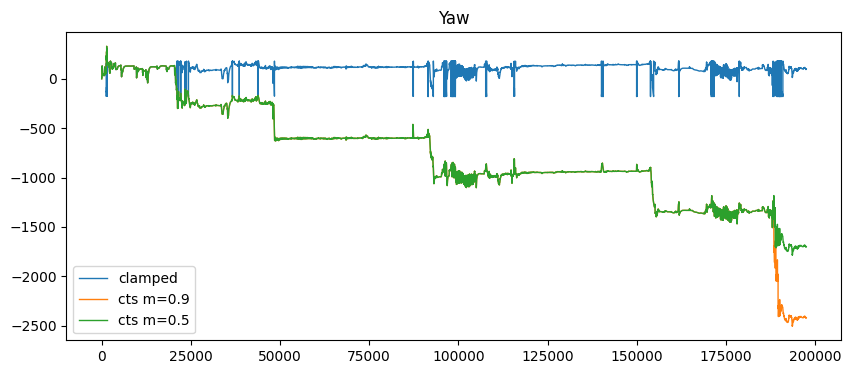

In [6]:
plotYaw(y_m9=patched_yaw_m9, y_m5=patched_yaw_m5)

Zooming to that diverging range:

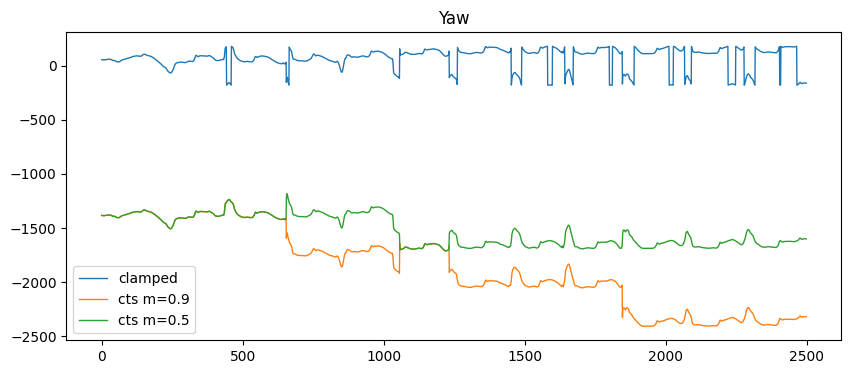

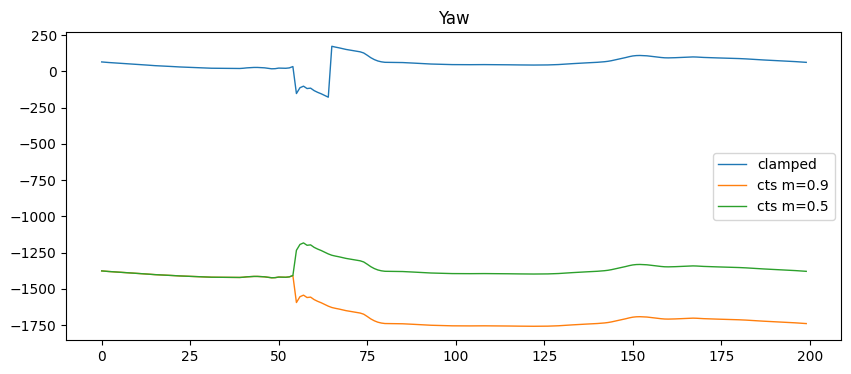

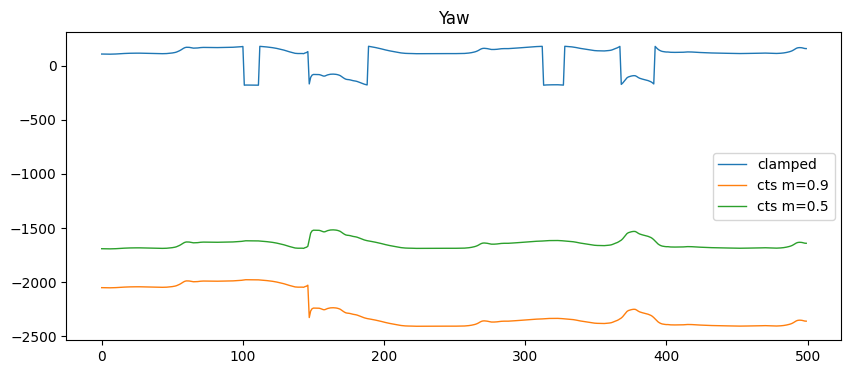

In [7]:
r_of_interest = [187800, 190300]
plotYaw(y_m9=patched_yaw_m9, y_m5=patched_yaw_m5, r=r_of_interest)
# this one is interesting... Hops 0 to -180, then -180 to +180. The first hop isn't fixed here since it's half scale magnitude
r_of_interest = [188400, 188600]
plotYaw(y_m9=patched_yaw_m9, y_m5=patched_yaw_m5, r=r_of_interest)
r_of_interest = [189500, 190000]
plotYaw(y_m9=patched_yaw_m9, y_m5=patched_yaw_m5, r=r_of_interest)

Using a coarse `m` does a better job at capturing any signal skipping due to clamping, since it's a matter of speed (doing 360s...)